In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [6]:
from datetime import datetime
import yfinance as yf

start_date = "2020-01-01"
end_date_forecast = "2025-07-25"
print(f"\nToday: {end_date_forecast}")

# Use correct ticker
ticker = "AAPL"

# Download data
data = yf.download(ticker, start=start_date, end=end_date_forecast)

# Extract high prices
d_high = data["High"]
length = len(data)

# Output results
print("\n===================================")
print(f"Company: {ticker}")
print(f"Length: {length}")
print("\n====================================")
print(d_high.tail(5))


/tmp/ipython-input-6-2170232683.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date_forecast)
[*********************100%***********************]  1 of 1 completed


Today: 2025-07-25

Company: AAPL
Length: 1397

Ticker            AAPL
Date                  
2025-07-18  211.789993
2025-07-21  215.779999
2025-07-22  214.949997
2025-07-23  215.149994
2025-07-24  215.690002


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


139/139 - 6s - 44ms/step - loss: 0.0111
Epoch 2/100
139/139 - 4s - 30ms/step - loss: 2.2213e-04
Epoch 3/100
139/139 - 2s - 16ms/step - loss: 1.8847e-04
Epoch 4/100
139/139 - 3s - 24ms/step - loss: 2.0834e-04
Epoch 5/100
139/139 - 4s - 29ms/step - loss: 1.8622e-04
Epoch 6/100
139/139 - 1s - 9ms/step - loss: 1.8203e-04
Epoch 7/100
139/139 - 1s - 9ms/step - loss: 1.7960e-04
Epoch 8/100
139/139 - 2s - 18ms/step - loss: 1.8385e-04
Epoch 9/100
139/139 - 1s - 9ms/step - loss: 1.9006e-04
Epoch 10/100
139/139 - 2s - 14ms/step - loss: 1.7565e-04
Epoch 11/100
139/139 - 2s - 13ms/step - loss: 2.0469e-04
Epoch 12/100
139/139 - 1s - 9ms/step - loss: 1.6663e-04
Epoch 13/100
139/139 - 1s - 10ms/step - loss: 1.8191e-04
Epoch 14/100
139/139 - 1s - 10ms/step - loss: 1.7341e-04
Epoch 15/100
139/139 - 2s - 18ms/step - loss: 2.0300e-04
Epoch 16/100
139/139 - 3s - 19ms/step - loss: 1.8759e-04
Epoch 17/100
139/139 - 3s - 21ms/step - loss: 1.6409e-04
Epoch 18/100
139/139 - 1s - 10ms/step - loss: 1.6845e-04
Epo

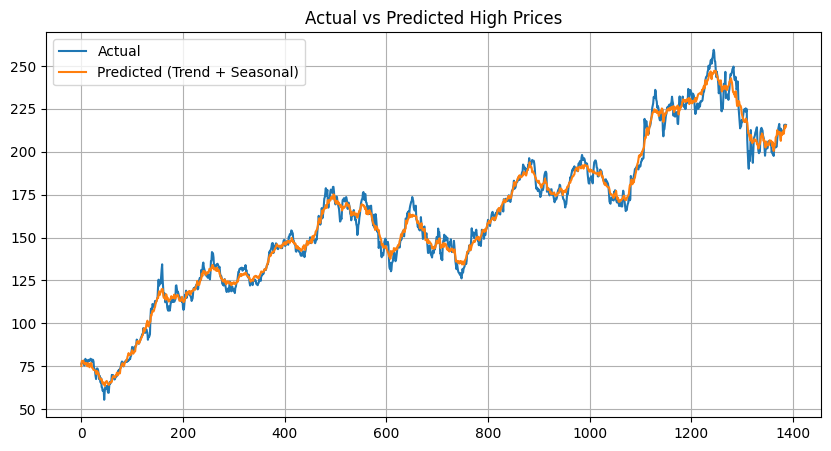

Final RMSE (Reconstructed): 4.2029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Forecast for Next Day (Trend + Seasonal): 215.2655


In [8]:
from statsmodels.tsa.seasonal import STL
stl = STL(d_high, period=30)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
resid = result.resid

def prepare_lstm_data(series, window_size):
    scaler = MinMaxScaler()
    # Handle potential NaN values by dropping them
    series = series.dropna()
    scaled = scaler.fit_transform(series.values.reshape(-1, 1))
    x, y = [], []
    for i in range(len(scaled) - window_size):
        x.append(scaled[i:i + window_size])
        y.append(scaled[i + window_size])
    return np.array(x), np.array(y), scaler, scaler # Return scaler here

window_size = 10
x_trend, y_trend, trend_scaler_x, trend_scaler_y = prepare_lstm_data(trend, window_size)
x_seasonal, y_seasonal, seasonal_scaler_x, seasonal_scaler_y = prepare_lstm_data(seasonal, window_size)

def build_and_train_lstm(x, y, epochs=100):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(x.shape[1], 1)),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(x, y, epochs=epochs, batch_size=10, verbose=2)
    return model

# Build and train models
model_trend = build_and_train_lstm(x_trend, y_trend)
model_seasonal = build_and_train_lstm(x_seasonal, y_seasonal)

# Make predictions
y_trend_pred = model_trend.predict(x_trend)
y_seasonal_pred = model_seasonal.predict(x_seasonal) # Use x_seasonal for prediction

# Inverse transform predictions
trend_pred = trend_scaler_y.inverse_transform(y_trend_pred)
seasonal_pred = seasonal_scaler_y.inverse_transform(y_seasonal_pred)

# Combine predictions
final_pred = trend_pred.flatten() + seasonal_pred.flatten()

# Plotting
# Adjust actual to match the length of final_pred after dropping NaNs and considering the window_size
# The actual values should correspond to the y values used for training the LSTM models
actual = d_high.dropna().values[window_size:window_size + len(y_trend)]


plt.figure(figsize=(10, 5))
plt.plot(actual, label="Actual")
plt.plot(final_pred, label="Predicted (Trend + Seasonal)")
plt.legend()
plt.grid(True)
plt.title("Actual vs Predicted High Prices")
plt.show()

rmse = np.sqrt(mean_squared_error(actual, final_pred))
print(f"Final RMSE (Reconstructed): {rmse:.4f}")

# Forecast for the next day
# Need to get the last 'window_size' data points from the original series for forecasting
last_trend_window = trend.dropna().values[-window_size:].reshape(1, window_size, 1)
last_trend_scaled = trend_scaler_x.transform(last_trend_window.reshape(window_size, 1)).reshape(1, window_size, 1)
next_trend_scaled = model_trend.predict(last_trend_scaled)
next_trend = trend_scaler_y.inverse_transform(next_trend_scaled)[0][0]

# Prepare data for seasonal forecasting
last_seasonal_window = seasonal.dropna().values[-window_size:].reshape(1, window_size, 1)
last_seasonal_scaled = seasonal_scaler_x.transform(last_seasonal_window.reshape(window_size, 1)).reshape(1, window_size, 1)
next_seasonal_scaled = model_seasonal.predict(last_seasonal_scaled)
next_seasonal = seasonal_scaler_y.inverse_transform(next_seasonal_scaled)[0][0]

next_day_forecast_high_LSTM = next_trend + next_seasonal
print(f"Forecast for Next Day (Trend + Seasonal): {next_day_forecast_high_LSTM:.4f}")